<a href="https://colab.research.google.com/github/mkhfring/Tutorial/blob/main/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background




The traditional models were basicly classifiers that aim to distinguish samples by drawing a line.

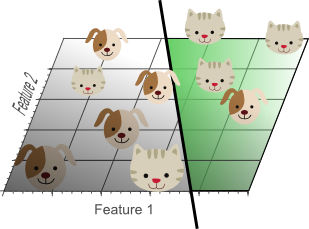

To have better models, non-linearity was proposed to capture more complicated functions

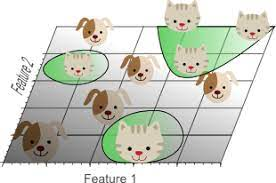

# Transformer architecture



For the purpos of this tutorial, lets download the data and make a simple encoding strategy. In this regard, we first make a sorted list of all unique charecters in the input data (Which is 65 for the data that we are working on).

 Then, we build two dictionaries for encoder and decoder. The dictionary for the encoder holds the index of each charector and the decoder do the same thing in reverse. This is called tokenization, which is simply converting text data to numbers. There are many strategies to do this (like google sentencePiece and openai tiktoken). However, for the sake of this tutorial we propose a very simple startegy to build the tokenizer. The reason that we have to make a tokenizer is that the mathematics, which powers the deep learning models only undrestand the numbers.

# New Section

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-08-15 07:14:04--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.01s   

2023-08-15 07:14:04 (83.2 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
print("length of dataset in characters: ", len(text))
print("\n\n##################\n\n")
print(text[:500])

length of dataset in characters:  1115394


##################


First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


In [ ]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [ ]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [ ]:
from traitlets.traitlets import Long
import torch
data = torch.tensor(encode(text), dtype=torch.long)
data[:500]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
        47, 59, 57,  1, 47, 57,  1, 41, 

In [ ]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

We don't sent the entier data to the model all at once. We send a chunk of data with a specific length. An example of 8 charectors in the data

In [ ]:
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [ ]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


In [ ]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    # generating `batch size` number of indices in the range of our data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

# for b in range(batch_size): # batch dimension
#     for t in range(block_size): # time dimension
#         context = xb[b, :t+1]
#         target = yb[b,t]
#         print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----


In [ ]:

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53, 56, 1, 58, 46] the target: 39
when input is [44, 53, 56, 1, 58, 46, 39] the target: 58
when input is [44, 53, 56, 1, 58, 46, 39, 58] the target: 1
when input is [52] the target: 58
when input is [52, 58] the target: 1
when input is [52, 58, 1] the target: 58
when input is [52, 58, 1, 58] the target: 46
when input is [52, 58, 1, 58, 46] the target: 39
when input is [52, 58, 1, 58, 46, 39] the t

## The bigram *model*

The first step here is to make a bigram model. This model would be inhereted from the pytorch nn.Module. First we make an embedding table in the constructor, which is basically a tensor of size vocab_Size * vocab_size. Then, each index will filter the row at idx position. In this simple scenario, the logits are the score of the next charector predicted by the information of the current char. It is posible to do this because some charectors are following each other in some cercumstance.

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BiGramModel(nn.Module):
  def __init__(self, vocab_size):
    super().__init__()
    self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

  def forward(self, idx, targets):
    logits = self.token_embedding_table(idx) # (B=4, T=8, C=65)
    return logits



m1 = BiGramModel(vocab_size)
output = m1(xb, yb)
print(output.shape)


tensor([[[-1.5101, -0.0948,  1.0927,  ..., -0.6126, -0.6597,  0.7624],
         [ 0.3323, -0.0872, -0.7470,  ..., -0.6716, -0.9572, -0.9594],
         [ 0.2475, -0.6349, -1.2909,  ...,  1.3064, -0.2256, -1.8305],
         ...,
         [ 0.5978, -0.0514, -0.0646,  ..., -1.4649, -2.0555,  1.8275],
         [ 1.0901,  0.2170, -2.9996,  ..., -0.5472, -0.8017,  0.7761],
         [ 0.3323, -0.0872, -0.7470,  ..., -0.6716, -0.9572, -0.9594]],

        [[ 1.0541,  1.5018, -0.5266,  ...,  1.8574,  1.5249,  1.3035],
         [-0.1324, -0.5489,  0.1024,  ..., -0.8599, -1.6050, -0.6985],
         [-0.6722,  0.2322, -0.1632,  ...,  0.1390,  0.7560,  0.4296],
         ...,
         [ 1.0901,  0.2170, -2.9996,  ..., -0.5472, -0.8017,  0.7761],
         [ 1.1513,  1.0539,  3.4105,  ..., -0.5686,  0.9079, -0.1701],
         [ 0.2475, -0.6349, -1.2909,  ...,  1.3064, -0.2256, -1.8305]],

        [[-0.2103,  0.4481,  1.2381,  ...,  1.3597, -0.0821,  0.3909],
         [ 0.2475, -0.6349, -1.2909,  ...,  1

Now, we need to define the loss. We can use the cross entropy loss in this case. Yet, we need to reshape our logits becuase pytorch loss expect the second input to be the number of channels. So, we will use view in this case. The loss that we will see after running this code will be approximately equal to -ln(1/65) since we have 65 channels


In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BiGramModel(nn.Module):
  def __init__(self, vocab_size):
    super().__init__()
    self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

  def forward(self, idx, targets):
    logits = self.token_embedding_table(idx) # (B=4, T=8, C=65)
    B, T, C = logits.shape
    logits = logits.view(B*T, C)
    targets = targets.view(B*T)
    loss = F.cross_entropy(logits, targets)
    return logits, loss



m2 = BiGramModel(vocab_size)
output, loss = m2(xb, yb)
print(loss)

tensor(4.8786, grad_fn=<NllLossBackward0>)


In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)
# torch.zeros((1, 1))
# This will generate a tensor of 1 by 1 that is 0. 0 stands for next line(\n).
# Then we call the generate on this tensor and we generate 1000 charector. After that we post process the result to be accepted by our decoder
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)

Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


Next step we need to create an optimizer and optimize the loss function.

In [ ]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [ ]:
batch_size = 32
for steps in range(10000): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

2.418886184692383


In [ ]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=400)[0].tolist()))



Ththe s chebro lrid,
Se'lan foowom ndiske
tukistlinas:

Orat lyowe wiclin:
ALLars t th cinod as!
Thevedevead;AEJUCaroftt,
ADerde hy s tr;
GSt cicoutrncolond p f IAwathaner:
ONat they t fo be gs blle weamyoure itintet in'sut loomalll ink!
F s sur,
Thaveine thayouditelfrenevecyowe tes, hile
Fas d,
TID:


OME sheve ind f bevk, nes kimad'T:
QUCEShaloro llomewileat t.

t lwntelllllen s! m harilet? l y


Each token only talks with previous tokens in the sequence since the model is auto regressive



In [ ]:
import torch
torch.manual_seed(1337)
B, T, C = 4,8,2
x = torch.randn(B, T, C)
x.shape

torch.Size([4, 8, 2])

In [ ]:
xbow = torch.zeros((B,T, C))
for b in range(B):
  for t in range(T):
    xprev = x[b, :t+1] #(t, C)
    xbow[b, t] = torch.mean(xprev, 0)

x[0]

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])

In [ ]:

xbow[0]

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])

Looking at x[0] and xbow[0], one can see that the first rows are equal. However, the second row of xbow is the average of the first and scond row in x[0]. Similarly, the last row of xbow[0] is the average of all rows in x[0]. Now we will introduce s more efficient way to do this.

In [ ]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
# a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[ 2.,  7.],
        [ 8., 11.],
        [14., 16.]])


In [ ]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [ ]:
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C)
torch.allclose(xbow, xbow2)

True

For the third version, we first define two matrises. trail that is a lower triangular matrix and wei that is a matrix of the size T*T with all elements zero. Then, we convert all zeros to -inf. The reason to do this is that our model is an auto regressive model and it cannot oversees the future.

In [ ]:
from torch.nn import functional as F
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei
# wei = F.softmax(wei, dim=-1)


tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

Now, by using softmax we will see a matrix very similar to `a = a / torch.sum(a, 1, keepdim=True)` in version 2. The reason for this is that softmax function first computes exponensial of all elements in each row and then normalizes them (calculates the average). So, the exponensial of zeros is 1 and -inf is 0.

In [ ]:
from torch.nn import functional as F
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
wei


tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

As a result, we can have a third version of the bag of words which is more efficient and we will use this to compute attention heads. This approach is effective because we will start with a matrix of zeros. This means tokens don't have any interaction at first. Then, during the training phase we will learn how much each token is interesting for other tokens (By computing weighted aggregation of previous tokens).

In [ ]:
from torch.nn import functional as F
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)

True

Now lets move toward implementing our first attention head. Version 3 of calculating average has a problem. It is uniform over all tokens. This is not desiered. For instance, a vowle may be more interested in a consonant in the past. Self attention solve this problem. In this regard, each token emits two different vectors: a query and a key. The query roughly speaking ask for information and the key roughly speaking indicates the information that the current token has. So, the dot product of the query vector of current node and the key vector of other nodes shows the importance of each node to this node.

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(1337)
B, T, C = 4,8,32
x = torch.randn(B, T, C)
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
k = key(x) #(B, T, 16)
q = query(x) # (B, T, 16)
wei = q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)
# Now we add the remaining parts of version 3
tril = torch.tril(torch.ones(T, T))
# wei = torch.zeros((T,T)) This part will be removed since now we dont start with zeros by start with q@k
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
out = wei @ x
out.shape

torch.Size([4, 8, 32])

In the self attention head of a transformer the value of x will not be used as is but it will be converted into something named value. value can be interpreted into the compunication that this node will contribute to other nodes if they are interested in it. So, the next version of the self attention head will be as follows:

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(1337)
B, T, C = 4,8,32
x = torch.randn(B, T, C)
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x) #(B, T, 16)
q = query(x) # (B, T, 16)
wei = q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)
# Now we add the remaining parts of version 3
tril = torch.tril(torch.ones(T, T))
# wei = torch.zeros((T,T)) This part will be removed since now we dont start with zeros by start with q@k
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
v = value(x)
out = wei @ v
out.shape

torch.Size([4, 8, 16])

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

In [ ]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

In [ ]:
k.var()

tensor(1.0449)

In [ ]:
q.var()

tensor(1.0700)

In [ ]:
wei.var()

tensor(1.0918)

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

batch_size = 64
block_size = 256
max_iters = 5000
eval_iterval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
eval_iters = 200
n_embed = 384
n_layers = 6
n_head = 6

#---------------
torch.manual_seed(1337)


with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)

stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]


def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    # generating `batch size` number of indices in the range of our data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            x, y = get_batch(split)
            logits, loss = model(x, y)
            losses[k] = loss.item()

        out[split] = losses.mean()

    model.train()
    return out


class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query =  nn.Linear(n_embed, head_size, bias=False)
        self.value =  nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x) # (B, T, C)
        q = self.query(x) # (B, T, C)
        wei = q @ k.transpose(-2, -1) * C**-0.5 #B, T, T
        wei = wei.masked_fill(self.tril[:T, :T] ==0, float('-inf'))
        wei = F.softmax(wei, dim=-1) #B, T, T
        v = self.value(x)
        out = wei @ v
        return out


class MultiHeadAttention(nn.Module):
    """multiple heads of self-attention in parallel"""

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed, n_embed)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # Concatinating over channel dimension
        out = self.proj(out)
        return out


class FeedForward(nn.Module):
    ''' a simple linear layer followd by a non-linearity'''

    """ before implementing this layer nodes where talking to each other, but they didn't have time to learn the
    the information that they have received through the comunication."""

    def __init__(self, n_embed):
        super().__init__()
        # After adding the residual connection we need to add projection layers to multihead attention and feed forward
        # layer. So, below we have added a new linear layer as projection. Following the original paper the first linear layer
        # is multiplied by 4. So, in the projection we will project 4 * embedding size to embedding size.
        self.net = nn.Sequential(
            nn.Linear(n_embed, 4 * n_embed),
            nn.ReLU(),
            nn.Linear(4 * n_embed, n_embed)
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    def __init__(self, n_embed, n_head):
        super().__init__()
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        # In most cases not only we need the embedding of tokens but also we need the embedding of
        # their positions. So, here we will add the positional embeddings
        self.postion_embedding_table = nn.Embedding(block_size, n_embed)

        # self.sa_heads = MultiHeadAttention(4, n_embed//4) # i.e. 4 heads of 8-dimensional self-attention (very similar to group convolution)
        # self.ffwd = FeedForward(n_embed)
        self.blocks = nn.Sequential(*[Block(n_embed=n_embed, n_head=n_head) for _ in range(n_layers)])
        # self.blocks = nn.Sequential(
        #     Block(n_embed, n_head=4),
        #     Block(n_embed, n_head=4),
        #     Block(n_embed, n_head=4),
        #     Block(n_embed, n_head=4),
        #     nn.LayerNorm(n_embed)
        # )
        self.ln_f = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        # idx and targets are both (B,T) tensor of integers
        # Instead of having vocab by vocab size we will use an embedding. So, we cannot compute
        # the logits directly and we need to add a linear layer (See the constructor of the model)
        token_embedding = self.token_embedding_table(idx) # (B,T,C_{embedding})
        # In next line torch.arrange will generate integers from 0 to T-1
        pos_embedding = self.postion_embedding_table(torch.arange(T, device=device)) #(T, C)
        # the addition below will use broadcasting in pytorch
        x = token_embedding + pos_embedding
        # x = self.sa_heads(x)
        # x = self.ffwd(x)
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x) #(B,T,C_{vocab_size})


        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):


            # Since we have positional embedding we can not allow a data larger than
            # the block_size. If we don't do this then the positional embedding table will go out of scope
            idx_cond = idx[:, -block_size:]

            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


model = BigramLanguageModel()
m = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters): # increase number of steps for good results...

    if iter % eval_iterval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss: {losses['train']:.4f} and eval loss: {losses['val']:.4f}")
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))

cuda
step 0: train loss: 4.2849 and eval loss: 4.2823
step 500: train loss: 1.9249 and eval loss: 2.0338


# Mini Grad (Forward and Backward computations)

# Bigram Model

# Transformer implementation in Details